# 1. SVM模型
SVM模型优化参数与特征工程 <br />
优化参数使用网格搜索法 <br />
特征工程主要使用kmer <br />
(1)首先测试未使用特征工程时模型的性能 <br />
(2)接着测试 2-kmer模型的性能 <br />
(3)然后测试 3-kmer模型的性能

# (1)未使用特征工程时模型的性能
这里不适用测试数据，只使用训练数据集与开发数据集

In [17]:
import numpy as np
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import time
from sklearn.model_selection import GridSearchCV


In [10]:
#加载数据
X_train = np.load("../temp_ann_data/X_train.npy")/4
X_dev = np.load("../temp_ann_data/X_dev.npy")/4
X_test = np.load("../temp_ann_data/X_test.npy")/4

y_train = np.load("../temp_ann_data/y_train.npy")
y_dev = np.load("../temp_ann_data/y_dev.npy")
y_test = np.load("../temp_ann_data/y_test.npy")


print('X:',X_train.shape,X_dev.shape,X_test.shape)
print('Y:',y_train.shape,y_dev.shape,y_test.shape)

X: (8844, 200) (2948, 200) (2948, 200)
Y: (8844,) (2948,) (2948,)


随机选一个参数运行，看看效果

In [12]:
start = time.time()
clf = SVC(C=100,gamma=1,kernel='rbf',probability=True)
clf.fit(X_train,y_train)
pred_prob = clf.predict_proba(X_dev)[:,1]
print('time:',time.time()-start)

time: 185.84539532661438


{'accuracy': 0.503,
 'precision': 0.503,
 'recall': 0.999,
 'f1': 0.669,
 'auc': 0.499}

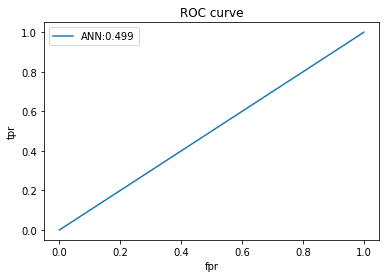

In [8]:
#评价模型
def assess(y_true,y_prob,roc=True,pr=False,poly_name=None,line_name=None):
    '''
    pass
    '''
    re={}
    y_pred =(y_prob+0.5).astype(int)
    
    re['accuracy'] = round(metrics.accuracy_score  (y_true,y_pred),3)
    re['precision'] = round(metrics.precision_score(y_true,y_pred),3)
    re['recall'] = round(metrics.recall_score      (y_true,y_pred),3)
    re['f1'] =  round(metrics.f1_score             (y_true,y_pred),3)
    re['auc'] = round(metrics.roc_auc_score        (y_true, y_prob),3)
    
    
    fpr,tpr,thresholds = metrics.roc_curve(y_true,y_prob)
    plt.plot(fpr,tpr,label= 'ANN:'+str(re['auc']))
    plt.title('ROC curve')
    plt.xlabel('fpr')
    plt.ylabel('tpr')
    
    #precision, recall, thresholds = metrics.precision_recall_curve(y_true,y_prob)
    #plt.plot(precision,recall,label='precison_and_recall')
    plt.legend()
    
    return re

assess(y_dev,pred_prob)

可以看出没有使用特征工程之前，SVM不能提取polyA的信息，<br />
而这也是有SVM的原理所决定，SVM尝试把每个位置位置当做特征，当每个碱基的碱基可以是A、T、C、G，<br />
无论正负样本,均不固定，这就导致SVM不能通过每个位置的碱基来产生一个超平面，来对样本进行划分 <br />
所以直接放弃这种方式

# (2)使用2-kmer的性能
由ANN的例子，我们只使用kmer的统计作为特征，以下均相同

In [13]:
def init_kmers_list(k):
    base  = ['1','2','3','4']
    kmers = ['1','2','3','4']
    def str_mult(base1, base2):
        return [j+i for j in base2 for i in base1]
    
    for i in range(k-1):
        kmers = str_mult(base,kmers)
    
    return kmers

def init_kmers_dict_count(k=2):
    kmers_list = init_kmers_list(k)
    kmers_dict_count={}
    for kmer in kmers_list:
        kmers_dict_count[kmer] = 0 
    return kmers_dict_count

def init_kmers_dict_num(k=2):
    kmers_list = init_kmers_list(k)
    kmers_dict={}
    for idx,kmer in enumerate(kmers_list):
        kmers_dict_num[kmer] = idx+1 
    return kmers_dict_num        

In [14]:
#使用2kmer
#第二遍运行报错，只需要运行一次，原始数据已经被修改
kmers_dict_count = init_kmers_dict_count(2)
def convert_to_kmers_count(x,k=2):
    count = kmers_dict_count.copy()
    seq = ""
    for i in x:        
        seq += str(i)

    for i in range(len(x)-k+1):
        count[seq[i:i+k]] += 1
    return np.array([value for key,value in count.items()])


# 加载数据
X_train = np.load("../temp_ann_data/X_train.npy")
X_dev = np.load("../temp_ann_data/X_dev.npy")
X_test = np.load("../temp_ann_data/X_test.npy")

y_train = np.load("../temp_ann_data/y_train.npy")
y_dev = np.load("../temp_ann_data/y_dev.npy")
y_test = np.load("../temp_ann_data/y_test.npy")

#转化数据
X_train = np.vstack([convert_to_kmers_count(a) for a in X_train])/16
X_dev = np.vstack([convert_to_kmers_count(a) for a in X_dev])/16
X_test = np.vstack([convert_to_kmers_count(a) for a in X_test])/16

print('X:',X_train.shape,X_dev.shape,X_test.shape)
print('Y:',y_train.shape,y_dev.shape,y_test.shape)

X: (8844, 16) (2948, 16) (2948, 16)
Y: (8844,) (2948,) (2948,)


与前面一样，先选一个较合适的参数，看看效果

In [15]:
start = time.time()
clf = SVC(C=100,gamma=1,kernel='rbf',probability=True)
clf.fit(X_train,y_train)
pred_prob = clf.predict_proba(X_dev)[:,1]
print('time:',time.time()-start)

time: 60.845062255859375


{'accuracy': 0.727,
 'precision': 0.73,
 'recall': 0.724,
 'f1': 0.727,
 'auc': 0.792}

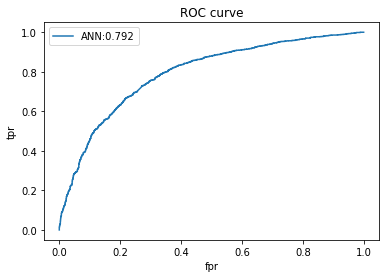

In [16]:
#评价模型
assess(y_dev,pred_prob)

可以看出当使用kmer时，SVM能够提取信息，对有限的kmer统计信息产生一个超平面<br />
进一步，使用网格搜索法，采用2折交叉验证寻找合适的参数

In [18]:
start = time.time()
#设定参数搜索空间
param_grid=[{'kernel':['linear','rbf'],
            'C':[1,10,100,300],
             'gamma':[0.1,1,10,100,300]} ]

model = GridSearchCV(SVC(),param_grid,cv=2,n_jobs = -1)
model.fit(X_train,y_train)
print(time.time()-start)

59.12692475318909


In [21]:
print(model.best_params_,model.best_score_,model.best_estimator_)

{'C': 300, 'gamma': 0.1, 'kernel': 'rbf'} 0.7530529172320217 SVC(C=300, gamma=0.1)


In [22]:
#使用新的参数重新训练
start = time.time()
clf = SVC(C=300,gamma=0.1,kernel='rbf',probability=True)
clf.fit(X_train,y_train)
pred_prob = clf.predict_proba(X_dev)[:,1]
print('time:',time.time()-start)

time: 36.27003788948059


{'accuracy': 0.771,
 'precision': 0.779,
 'recall': 0.761,
 'f1': 0.77,
 'auc': 0.851}

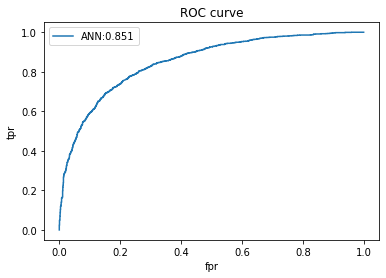

In [24]:
#评价模型
assess(y_dev,pred_prob)

使用参数搜索后，模型性能得到一些提升

# (3)使用3-mer的性能

In [28]:
#使用2kmer
#第二遍运行报错，只需要运行一次，原始数据已经被修改
kmers_dict_count = init_kmers_dict_count(3)
def convert_to_kmers_count(x,k=3):
    count = kmers_dict_count.copy()
    seq = ""
    for i in x:        
        seq += str(i)

    for i in range(len(x)-k+1):
        count[seq[i:i+k]] += 1
    return np.array([value for key,value in count.items()])


# 加载数据
X_train = np.load("../temp_ann_data/X_train.npy")
X_dev = np.load("../temp_ann_data/X_dev.npy")
X_test = np.load("../temp_ann_data/X_test.npy")

y_train = np.load("../temp_ann_data/y_train.npy")
y_dev = np.load("../temp_ann_data/y_dev.npy")
y_test = np.load("../temp_ann_data/y_test.npy")

#转化数据,使得数据均在0到1之间
X_train = np.vstack([convert_to_kmers_count(a) for a in X_train])/32
X_dev = np.vstack([convert_to_kmers_count(a) for a in X_dev])/32
X_test = np.vstack([convert_to_kmers_count(a) for a in X_test])/32

print('X:',X_train.shape,X_dev.shape,X_test.shape)
print('Y:',y_train.shape,y_dev.shape,y_test.shape)

X: (8844, 64) (2948, 64) (2948, 64)
Y: (8844,) (2948,) (2948,)


选一个较合适的参数看看效果

In [34]:
from sklearn.svm import SVC
import time
start = time.time()
clf = SVC(C=100,gamma=1,kernel='rbf',probability=True)
clf.fit(X_train,y_train)
pred_prob = clf.predict_proba(X_dev)[:,1]
print('time:',time.time()-start)

time: 65.15610837936401


{'accuracy': 0.793,
 'precision': 0.801,
 'recall': 0.783,
 'f1': 0.792,
 'auc': 0.871}

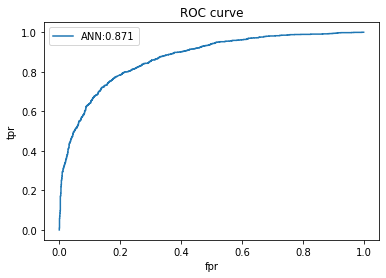

In [35]:
#评价模型
assess(y_dev,pred_prob)

当使用3-kmer时模型性能又得到一些提升<br />
使用网格搜索，寻找合适参数

In [36]:
param_grid=[{'kernel':['linear','rbf'],
            'C':[1,10,100,300],
             'gamma':[0.1,1,10,100,300]} ]

model = GridSearchCV(SVC(),param_grid,cv=2,n_jobs = -1)
model.fit(X_train,y_train)
print(time.time()-start)

269.34149837493896


In [37]:
print(model.best_params_,model.best_score_,model.best_estimator_)

{'C': 300, 'gamma': 0.1, 'kernel': 'rbf'} 0.7908186341022161 SVC(C=300, gamma=0.1)


In [38]:
#使用新的参数重新训练
start = time.time()
clf = SVC(C=300,gamma=0.1,kernel='rbf',probability=True)
clf.fit(X_train,y_train)
pred_prob = clf.predict_proba(X_dev)[:,1]
print('time:',time.time()-start)

time: 41.46234631538391


{'accuracy': 0.807,
 'precision': 0.809,
 'recall': 0.806,
 'f1': 0.807,
 'auc': 0.887}

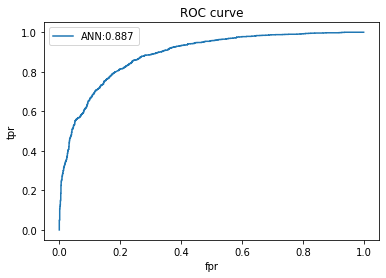

In [39]:
#评价模型
assess(y_dev,pred_prob)

{'accuracy': 0.798,
 'precision': 0.798,
 'recall': 0.803,
 'f1': 0.8,
 'auc': 0.884}

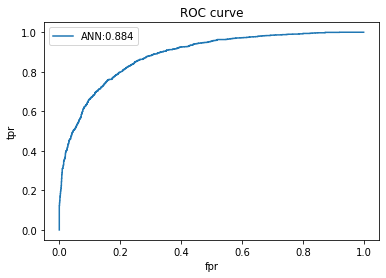

In [40]:
#评价模型
pred_prob = clf.predict_proba(X_test)[:,1]
assess(y_test,pred_prob)

# 保存SVM模型的结果

In [41]:
np.save("../save_pred/SVM_kmer_pred_proba.npy",pred_prob)
np.save("../save_pred/SVM_kmer_pred_y.npy",y_test)

# (4)使用5-kmer

In [44]:
#使用2kmer
#第二遍运行报错，只需要运行一次，原始数据已经被修改
kmers_dict_count = init_kmers_dict_count(4)
def convert_to_kmers_count(x,k=4):
    count = kmers_dict_count.copy()
    seq = ""
    for i in x:        
        seq += str(i)

    for i in range(len(x)-k+1):
        count[seq[i:i+k]] += 1
    return np.array([value for key,value in count.items()])


# 加载数据
X_train = np.load("../temp_ann_data/X_train.npy")
X_dev = np.load("../temp_ann_data/X_dev.npy")
X_test = np.load("../temp_ann_data/X_test.npy")

y_train = np.load("../temp_ann_data/y_train.npy")
y_dev = np.load("../temp_ann_data/y_dev.npy")
y_test = np.load("../temp_ann_data/y_test.npy")

#转化数据,使得数据均在0到1之间
X_train = np.vstack([convert_to_kmers_count(a) for a in X_train])/32
X_dev = np.vstack([convert_to_kmers_count(a) for a in X_dev])/32
X_test = np.vstack([convert_to_kmers_count(a) for a in X_test])/32

print('X:',X_train.shape,X_dev.shape,X_test.shape)
print('Y:',y_train.shape,y_dev.shape,y_test.shape)

X: (8844, 256) (2948, 256) (2948, 256)
Y: (8844,) (2948,) (2948,)


time: 207.12180304527283


{'accuracy': 0.794,
 'precision': 0.792,
 'recall': 0.803,
 'f1': 0.797,
 'auc': 0.871}

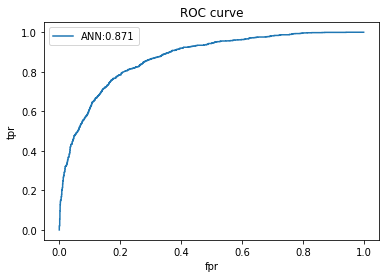

In [45]:
from sklearn.svm import SVC
import time
start = time.time()
clf = SVC(C=100,gamma=1,kernel='rbf',probability=True)
clf.fit(X_train,y_train)
pred_prob = clf.predict_proba(X_dev)[:,1]
print('time:',time.time()-start)

#评价模型
pred_prob = clf.predict_proba(X_test)[:,1]
assess(y_test,pred_prob)